## RLlib

In [1]:
# HIDDEN
import gym
import numpy as np
import matplotlib.pyplot as plt

#### What about the learning?

Let's return to the "API" of RL:

![](img/RL-API.png)

- We've talked about the input (environment) and output (policy)
- Let's talk about the reinforcement learning!

#### What we'll cover

- Many, many supervised learning algorithms exist... random forests, logistic regression, neural networks, etc.
- Likewise, there are many RL algorithms.
- This is not a course on RL algorithms, though many good ones exist!
- This course is about _applying_ RL.

#### Introducing Ray RLlib

![](img/rllib-logo.png)

- In this course we'll use Ray RLlib as our "scikit-learn of reinforcement learning"
- We will look under the hood only as needed, and focus on the inputs and outputs.

#### Our first RLlib code

First, we import RLlib, which is part of the Ray project:

In [2]:
from ray import rllib

Next, we create a trainer object. 

In [3]:
# HIDDEN
trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "env_config"            : {"is_slippery" : False}}

In [4]:
trainer = rllib.agents.ppo.PPOTrainer(env="FrozenLake-v1", 
                                      config=trainer_config)

- `PPOTrainer`: we're using the PPO algorithm
- `env="FrozenLake-v1"`: RLlib knows about OpenAI Gym environments
  - In the next module we'll learn how to make our own environments!
- `config=trainer_config`: this contains all hyperparameters of the algorithm and the environment.
  - For clarity we've hidden the config for now, but we'll get back to it soon.

#### Using the policy

- We haven't trained the agent yet, but we can still see what it does.
- This is like calling `predict` before running `fit` with supervised learning.

In [5]:
env = gym.make("FrozenLake-v1", is_slippery=False)
obs = env.reset()
obs

0

In [6]:
# HIDDEN
env.seed(3);

In [7]:
action = trainer.compute_single_action(obs, explore=False)
action

0

- We gave the trainer our initial observation, 0, and it recommended action 0 (left).
- This action came from the initialized **policy**.
- Remember, the policy maps observations to actions.
- For now we'll ignore the `explore=False`.

#### Using the policy

We can see what happened after taking that action:

In [8]:
obs, reward, done, _ = env.step(action)
env.render()

  (Left)
SFFF
FHFH
FFFH
HFFG


In [9]:
# HIDDEN
# Apparently, we attempted to move left but actually moved down, because we're in the slippery environment. 

#### Training

- So far our policy was just a random/arbitrary initialization.
- What we want is to train it _based on experience interacting with the environment_.
- In order to do this, RLlib will _play through many episodes_ and learn as it goes.

In [10]:
train_info = trainer.train()

- Note that, unlike sklearn's `fit()`, here we don't provide the dataset to `train()`.
- We gave it the environment during initialization, and it uses the environment to generate data.

#### Training iterations

- In fact, what we just did was one _iteration_ of training.
- RLlib will play through a bunch of episodes per iteration, depending on its hyperparameters.

In [11]:
len(train_info["hist_stats"]["episode_lengths"])

516

Looks like it ran ~500 episodes in that one iteration.

#### RL mindset: data generation

- This is a key departure from the supervised learning mindset
- In SL, we take a fixed amount of data and train for some number of iterations
- In RL, more iterations means more training _on more data_ because we learn from the environment as we interact with it
- If you only play one episode, you might never see observation 10, so how can you learn what to do given observation 10?

#### Training info: episode lengths

Let's look at the lengths of the last 100 episodes we played:

In [12]:
print(train_info["hist_stats"]["episode_lengths"][-100:])

[4, 6, 3, 4, 9, 13, 8, 8, 4, 7, 5, 5, 7, 16, 16, 7, 2, 5, 4, 14, 3, 7, 4, 14, 3, 5, 7, 10, 2, 5, 17, 9, 27, 6, 7, 7, 19, 5, 18, 8, 4, 5, 3, 2, 11, 11, 18, 4, 15, 9, 6, 2, 8, 13, 7, 6, 5, 25, 2, 2, 6, 2, 2, 10, 8, 18, 9, 4, 6, 21, 3, 4, 14, 12, 4, 12, 7, 16, 11, 18, 7, 3, 8, 5, 8, 5, 6, 6, 5, 7, 5, 9, 3, 4, 9, 9, 8, 17, 14, 2]


- Remember that an episode ends when `.step()` returns `True` for the `done` flag.
- We see some very short episodes, where the agent fell into a hole right away.

#### Training info: episode rewards

- For those longer episodes, did the agent reach the goal?
- To assess this, we can print out the first 100 _episode rewards_:

In [13]:
print(train_info["hist_stats"]["episode_reward"][-100:])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [14]:
print(np.mean(train_info["hist_stats"]["episode_reward"][-100:]))

0.0


- This is not very impressive. Let's keep training.

#### More training

In [15]:
for i in range(10):
    train_info = trainer.train()

In [16]:
print(np.mean(train_info["hist_stats"]["episode_reward"][-100:]))

0.99


- Nice! Now we're reaching the goal almost every time!
- The _average reward_ (across 100 episodes) is 0.99.
- Interpretation: we're reaching the goal 99% of the time.
- Why? Because in this environment, we only receive a reward at the end of the episode, 0 for failure and 1 for success.

#### Declare victory?

- We did well.
- But, this non-slippery Frozen Lake is a very easy environment. 
- Kind of like a supervised learning dataset where y=x would be "easy".
- Later we'll ramp up the difficulty.

#### Using the policy

We can run the **observation-policy-action loop** for multiple time steps to watch the policy in action:

In [17]:
obs = env.reset()

for i in range(3):
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


#### Using the policy

In [18]:
for i in range(3):
    action = trainer.compute_single_action(obs, explore=False)
    obs, reward, done, _ = env.step(action)
    env.render()

  (Down)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG
  (Right)
SFFF
FHFH
FFFH
HFFG


Using this policy we reliably reach the goal every time because the non-slippery Frozen Lake environment is deterministic.

#### sklearn / RLlib analogies

- We've seen some analogies (and departures) between SL and RL, both in concept and syntax. 
- Let's compare:

| SL/sklearn | RL/RLlib | Description  |
|-------------|---------|--------------|
| `ModelName(**hypers)` | `AlgoName(hypers, env)` | Initialize a model/algorithm |
| `.fit(X,y)`  | `.train()` | Training (fully for sklearn, one iteration for RLlib) |
| `.predict(x)` | `.compute_single_action(obs)` | Use the trained model once |
| `.score(X,y)` | `.evaluate` | Evaluate the model |

#### Evaluation

In RLlib, we can evaluate with `.evaluate()`:

In [19]:
eval_results = trainer.evaluate()

The evaluation output contains a lot of info. Let's look at a couple pieces:

In [20]:
eval_results["evaluation"]["episode_reward_mean"]

0.9836601307189542

That is, we reached the goal in 98% of the evaluation episodes. 

#### Evaluation

Histogram of episode rewards:

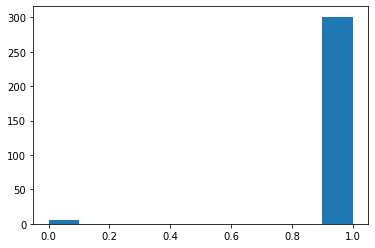

In [21]:
plt.hist(eval_results["evaluation"]["hist_stats"]["episode_reward"]);

#### Evaluation

Histogram of episode _lengths_:

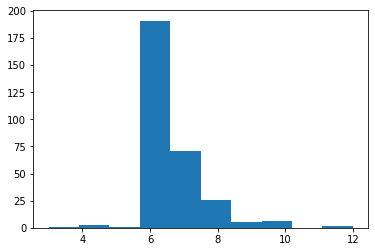

In [22]:
plt.hist(eval_results["evaluation"]["hist_stats"]["episode_lengths"]);

- The short ones are the failures, since it's impossible to reach the goal in 4 steps.
- Most of the time we reach the goal in the minimum number of steps (6).

#### Configuring the trainer

```python
trainer = rllib.agents.ppo.PPOTrainer(env="FrozenLake-v1", 
                                      config=trainer_config)
```

Remember this line? Earlier, we hid the `trainer_config`. Here's the config we hid:

```python
trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "env_config"            : {"is_slippery" : False}}
```

#### Configuring the trainer

```python
trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "env_config"            : {"is_slippery" : False}}
```

- `config={"framework" : "torch"}`: RLlib works with tensorflow (`"tf"` or `"tf2"`) and pytorch (`"torch"`)
- `"create_env_on_driver" : True`: This relates to Ray, and we will touch on it briefly, but not much in this course
-  `"seed" : 0`: This is used for reproducibility of the teaching materials, and is not normally needed
- `"env_config" : {"is_slippery" : False}`: this selects the non-slippery Frozen Lake
  - All environment hyperparameters go in this sub-dictionary

#### Let's apply what we learned!

## RLlib trainer methods

#### Training

_Which of the following most accurately describes the role of `trainer.train()` in RLlib?_

- [ ] It neither collects a data set of episodes nor learns a policy. | Are you sure?
- [ ] It learns a policy from a fixed data set of episodes. | Remember, calling train() causes the agent to play through episodes.
- [ ] It creates a data set of episodes but does not learn a policy. | Remember, calling train() learns a policy.
- [x] It simultaneously collects a data set of episodes and also learns a policy. | You got it!

#### Passing in the dataset

_When using scikit-learn for supervised learning we call `fit(X,y)`, but with RLlib we call `train()` without passing in the dataset. Why?_

- [x] Because RLlib was given access to the environment when the trainer was initialized, and this is all it needs.
- [ ] Because reinforcement learning does not involve data.
- [ ] Because X and y are passed into a different RLlib method.

#### Scoring

_Which of the following RLlib trainer methods is most analogous to scikit-learn's `.predict()` function?_

- [ ] `train` | This is more like `fit` in scikit-learn.
- [x] `compute_single_action` | Correct!
- [ ] `evaluate` | This is more like `score()` in scikit-learn. 

## Slippery Frozen Lake

In the slides, we trained an agent to reliably reach the goal in the **non-slippery** Frozen Lake environment. Here, try the same thing with the **slippery** Frozen Lake. Train your agent until it reaches the goal at least 20% of the time. Then, answer the multiple choice question below.

In [23]:
from ray import rllib

slippery_trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "env_config"            : {"is_slippery" : True}}

slippery_trainer = rllib.agents.ppo.PPOTrainer(____)

for i in range(____):
    train_info = slippery_trainer.____()
    
eval_results = ____.evaluate()

print(eval_results["evaluation"]["episode_reward_mean"])

NameError: name '____' is not defined

In [27]:
# BEGIN SOLUTION
from ray import rllib

slippery_trainer_config = {
    "framework"             : "torch",
    "create_env_on_driver"  : True,
    "seed"                  : 0,
    "env_config"            : {"is_slippery" : True},
    "evaluation_config"     : {"explore" : False}}

slippery_trainer = rllib.agents.ppo.PPOTrainer(env="FrozenLake-v1", config=slippery_trainer_config)

for i in range(12): # There is randomness here, but 12 should be enough most of the time
    train_info = slippery_trainer.train()
    
eval_results = slippery_trainer.evaluate()

print("Frequency of reaching goal: %.1f%%" % (eval_results["evaluation"]["episode_reward_mean"]*100))

print("Action performed from top-right:", slippery_trainer.compute_single_action(3, explore=False))
# END SOLUTION

Frequency of reaching goal: 32.9%
Action performed from top-right: 3


#### Action performed from top-right

What action is performed when the agent is at the top-right of the arena? This is printed out by the code.

- [ ] left (0) | When we ran the code, we got something different here.
- [ ] down (1) | When we ran the code, we got something different here.
- [ ] right (2) | When we ran the code, we got something different here.
- [x] up (3) | You got it!

#### Interpreting the policy

Recall that the arena looks like this:

```
SFFF
FHFH
FFFH
HFFG
```

In this slippery environment, you do your intended action 1/3 of the time, and each of the two perpendicular directions 1/3 of the time. You never go the opposite of the intended direction.

In the previous question, we saw that, from the **top-right corner** (observation 3), the agent tries to move up (action 3). Why do you think this is?

- [ ] "Up" is an arbitrary choice because we did not train the agent.
- [ ] The agent receives a reward for the "up" action. 
- [x] The agent wants to avoid falling into the hole below it, so the "up" action is the safest choice.
- [ ] Moving up brings the agent closer to the goal.

## Ex 3

In [25]:
# HIDDEN
from ipywidgets import Output
from IPython import display
import time

In [26]:
# TODO: should I switch from PPO to DQN so that I don't need explore=False when getting an action? and from evaluation config.